In [95]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from astropy.io import ascii
from astropy import constants as c, units as u
from scipy.interpolate import interp1d
from collections import OrderedDict
import seaborn as sns

sns.set_style("ticks", {"xtick.direction": u"in", "ytick.direction": u"in"})
fontsize = 12
plt.rc("font", **{"family": "sans-serif", "serif": ["Arial"]})
plt.rc("xtick", labelsize=fontsize)
plt.rc("ytick", labelsize=fontsize)

files = ("J1059_blue.dat","J1059_orange.dat","J1059_green.dat","J1059_red.dat","J1059_purple.dat")
title = ('Blue region','Orange region','Green region', 'Red region', 'Purple region')
abslines = OrderedDict(
    [
        ("SiIIa", 1260.4221),
        ("OI", 1302.1685),
        ("SiIIb", 1304.3702),
        ("CII", 1334.5323),
        ("SiIVa", 1393.7602),
        ("SiIVb", 1402.7729),
    ]
)

# need better wavelengths
bluelines = OrderedDict(
    [
        ("CIII", 977),
        ("OI", 989),
        ("CII", 1036),
        ("SIVFeII", 1063),
        ("FeII", 1122),
        ("FeIIb", 1143),
        ("CIIIb", 1176),
        ("SiIIa", 1190),
        ("SiIIb", 1193),
        ("SiIII", 1207),
    ]
)

lymanlinelist = [1215.7, 1025.7, 972.54, 949.74, 937.80]

# absorption system at z=2.3865
foreground_lymanlines = np.array(lymanlinelist) * 3.3865 / 3.79

# # comprehensive line list from Bethan
# all_lines = ascii.read("all_lines.list")
# all_lines_wave = all_lines["lambda"]
# all_lines_label = all_lines["transition"]

# define continuum windows
# we will fit to the median flux and mean wavelength within each window
windows = np.array(
    [
        [1254, 1257],
        [1265, 1280],
        [1281, 1298],
        [1313, 1330],
        [1343, 1363],
        [1364, 1388],
        [1407, 1415],
        [1434, 1455],
    ]
)

n_windows = np.shape(windows)[0]

In [96]:
def fit_continuum(n_windows, wave, flux):
    wave_to_fit = np.zeros(n_windows) * wave.unit
    flux_to_fit = np.zeros(n_windows) * flux.unit

    for i in range(n_windows):
        if windows[i][0] > min(wave.value):
            waves = wave[(wave.value > windows[i][0]) & (wave.value < windows[i][1])]
            fluxes = flux[(wave.value > windows[i][0]) & (wave.value < windows[i][1])]
            wave_to_fit[i] = np.mean(waves)
            flux_to_fit[i] = np.median(fluxes)

    waverange = (wave.value > wave_to_fit[0].value) & (
        wave.value < wave_to_fit[-1].value
    )
    # fit spline to median fluxes in windows
    contfunc = interp1d(wave_to_fit, flux_to_fit, kind="cubic")
    contfit = contfunc(wave[waverange])
    norm = flux[waverange] / contfit
    return (waverange, wave_to_fit, flux_to_fit, contfit, norm)


# define function that will find index of pixel with
# nearest wavelength to rest wavelength
def find_nearest(array, value):
    index = (np.abs(array - value)).argmin()
    return index


def measure_absline(wave, flux, line, lineup, linedown):
    """
	ew=measure_ew(wave, flux, line)
	returns the equivalent width (in the same units as "wave"),
	equivalent width-weighted velocity, maximum blueshifted velocity
	for the absorption line closest in wavelength to "line"
	"""
    # no units
    wave = wave.value
    flux = flux.value
    disp = np.mean(np.diff(wave))
    

    # we'll look for minimum flux within some number of pixels near expected line
    # dispersion is ~120 km/s per pixel
    bluesearch = 5
    redsearch = 2

    index = find_nearest(wave, line)
    # find index of minimum flux near expected line
    min_index = (index - bluesearch) + flux[index - bluesearch : index + redsearch].argmin()
    # check this
    if flux[min_index] != flux[index - bluesearch : index + redsearch].min():
        print("Minimum point is wrong!")
    
    ind = 1070
    # get index of upper wavelength limit
    # first element above min_index with flux > 1
    uplimit = min_index + (flux[min_index:] > 1).nonzero()[0][0]
    if wave[uplimit] > 1334.5323 and wave[uplimit] > lineup:
        uplimit = ind
    # get index of lower wavelength limit
    # last element below min_index with flux > 1
    # set to minimum wavelength of spectrum if no values have flux > 1
    try:
        downlimit = (flux[:min_index] > 1).nonzero()[0][-1]
    except:
        downlimit = np.where(wave == minwave)[0][0]
    if wave[downlimit] > 1334.5323 and wave[downlimit] < linedown:
        downlimit = ind + 1
    # to calculate equivalent width, subtract total flux from continuum
    # and multiply by dispersion
    # we want to integrate the area between the line and the continuum level
    # flux has units of erg/s/cm^2/angstrom
    # so we need to add up the fluxes and multiply by angstroms/pixel
    # velocities are in km/s
    ew = disp * np.sum(1 - flux[downlimit:uplimit])
    cent = np.sum(disp * (1 - flux[downlimit:uplimit]) * wave[downlimit:uplimit]) / ew
    vel = (cent - line) / line * c.c.to(u.km / u.s)
    maxvel = (wave[downlimit] - line) / line * c.c.to(u.km / u.s)
    # absorption line EWs are negative
    ew = -ew * u.angstrom
    return ew, vel, maxvel, wave[downlimit], wave[uplimit]

In [97]:
def fit_continuum(n_windows, wave, flux):
    wave_to_fit = np.zeros(n_windows) * wave.unit
    flux_to_fit = np.zeros(n_windows) * flux.unit

    for i in range(n_windows):
        if windows[i][0] > min(wave.value):
            waves = wave[(wave.value > windows[i][0]) & (wave.value < windows[i][1])]
            fluxes = flux[(wave.value > windows[i][0]) & (wave.value < windows[i][1])]
            wave_to_fit[i] = np.mean(waves)
            flux_to_fit[i] = np.median(fluxes)

    waverange = (wave.value > wave_to_fit[0].value) & (
        wave.value < wave_to_fit[-1].value
    )
    # fit spline to median fluxes in windows
    contfunc = interp1d(wave_to_fit, flux_to_fit, kind="cubic")
    contfit = contfunc(wave[waverange])
    norm = flux[waverange] / contfit
    return (waverange, wave_to_fit, flux_to_fit, contfit, norm)


# define function that will find index of pixel with
# nearest wavelength to rest wavelength
def find_nearest(array, value):
    index = (np.abs(array - value)).argmin()
    return index


def measure_absline(wave, flux, line, lineup, linedown):
    """
	ew=measure_ew(wave, flux, line)
	returns the equivalent width (in the same units as "wave"),
	equivalent width-weighted velocity, maximum blueshifted velocity
	for the absorption line closest in wavelength to "line"
	"""
    # no units
    wave = wave.value
    flux = flux.value
    disp = np.mean(np.diff(wave))
    

    # we'll look for minimum flux within some number of pixels near expected line
    # dispersion is ~120 km/s per pixel
    bluesearch = 5
    redsearch = 2

    index = find_nearest(wave, line)
    # find index of minimum flux near expected line
    min_index = (index - bluesearch) + flux[index - bluesearch : index + redsearch].argmin()
    # check this
    if flux[min_index] != flux[index - bluesearch : index + redsearch].min():
        print("Minimum point is wrong!")
    
    ind = 1070
    # get index of upper wavelength limit
    # first element above min_index with flux > 1
    uplimit = min_index + (flux[min_index:] > 1).nonzero()[0][0]
    if wave[uplimit] > 1334.5323 and wave[uplimit] > lineup:
        uplimit = ind
    # get index of lower wavelength limit
    # last element below min_index with flux > 1
    # set to minimum wavelength of spectrum if no values have flux > 1
    try:
        downlimit = (flux[:min_index] > 1).nonzero()[0][-1]
    except:
        downlimit = np.where(wave == minwave)[0][0]
    if wave[downlimit] > 1334.5323 and wave[downlimit] < linedown:
        downlimit = ind + 1
    # to calculate equivalent width, subtract total flux from continuum
    # and multiply by dispersion
    # we want to integrate the area between the line and the continuum level
    # flux has units of erg/s/cm^2/angstrom
    # so we need to add up the fluxes and multiply by angstroms/pixel
    # velocities are in km/s
    ew = disp * np.sum(1 - flux[downlimit:uplimit])
    cent = np.sum(disp * (1 - flux[downlimit:uplimit]) * wave[downlimit:uplimit]) / ew
    vel = (cent - line) / line * c.c.to(u.km / u.s)
    maxvel = (wave[downlimit] - line) / line * c.c.to(u.km / u.s)
    # absorption line EWs are negative
    ew = -ew * u.angstrom
    return ew, vel, maxvel, wave[downlimit], wave[uplimit]

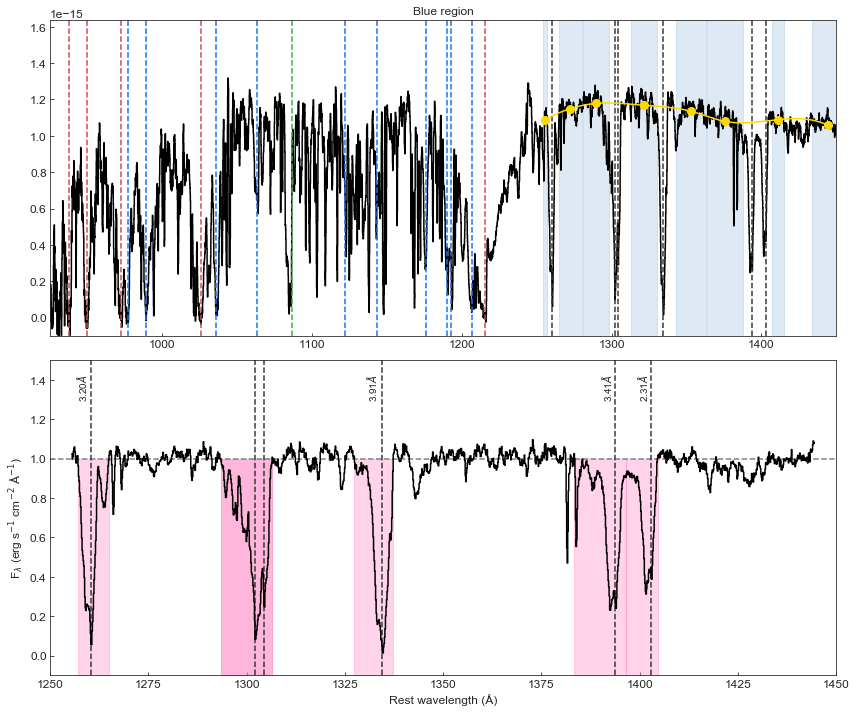

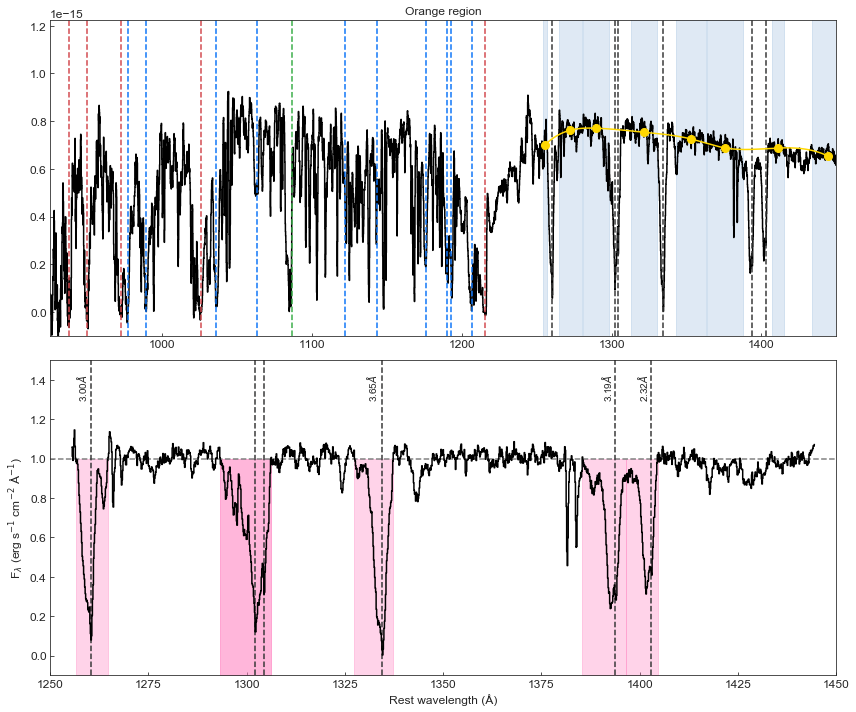

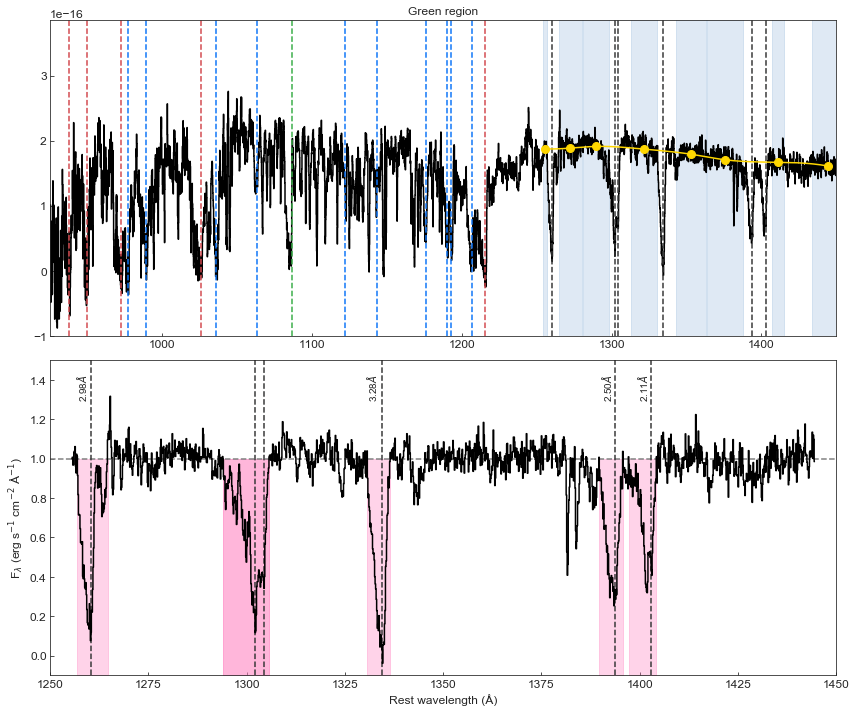

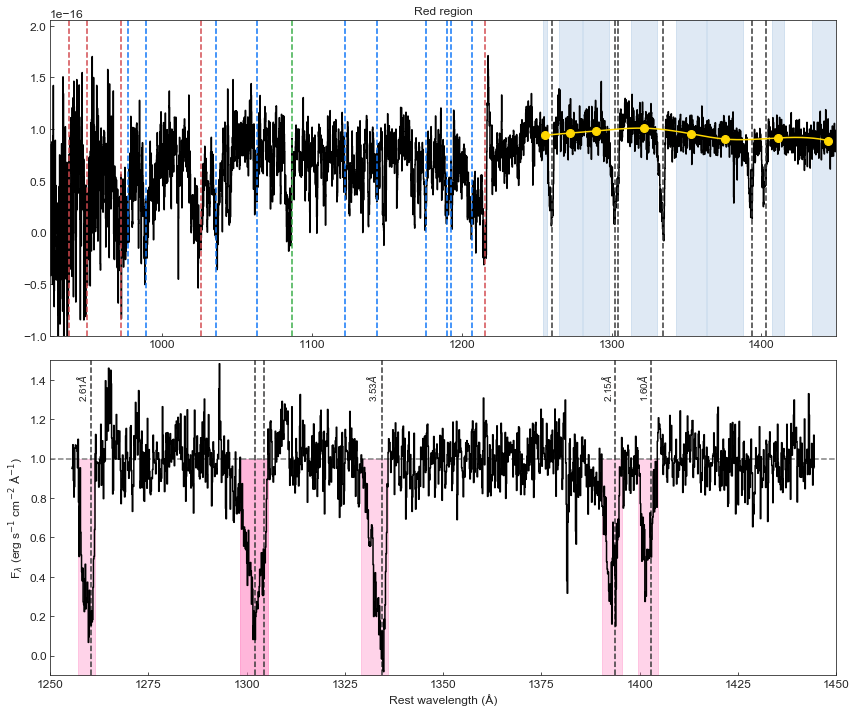

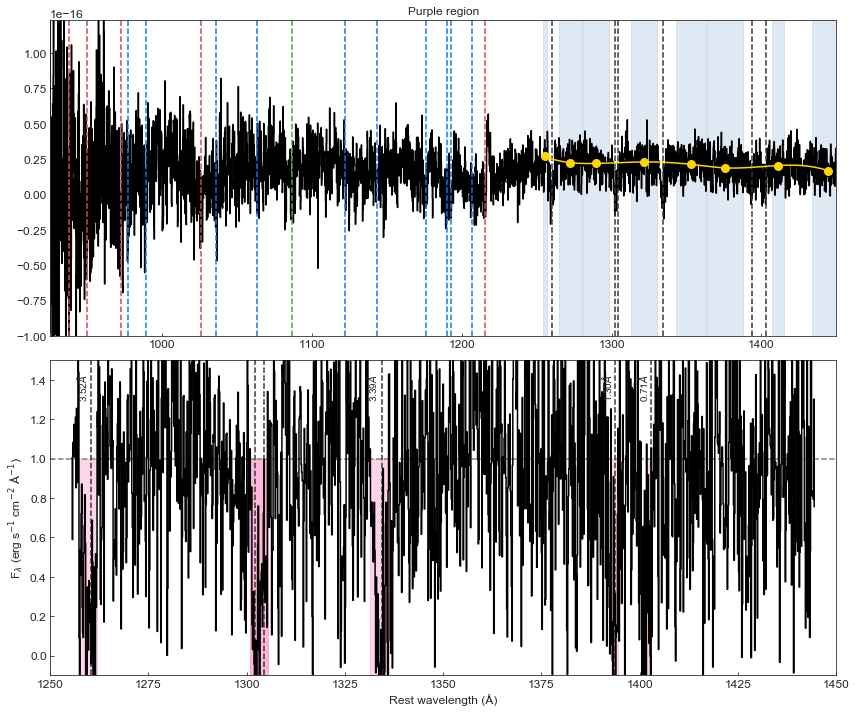

In [104]:
for i in range(len(files)):
    data = ascii.read(files[i])
    wavelength = data["restwave"] * u.angstrom
    flux = data["flux"] * u.erg / u.s / u.cm ** 2 / u.angstrom

    waverange, wave_to_fit, flux_to_fit, contfit, norm = fit_continuum(
        n_windows, wavelength, flux
    )


    lines_to_measure = list(abslines.values())
    line1 = [1302.1685, 1304.3702, 1334.5323, 1393.7602, 1402.7729, 1425]
    line2 = [0,1260.4221, 1302.1685, 1304.3702, 1334.5323, 1393.7602]
    # results of direct integration
    ew = np.zeros(len(lines_to_measure)) * u.angstrom
    minwave = np.zeros(len(lines_to_measure))
    maxwave = np.zeros(len(lines_to_measure))
    vel = np.zeros(len(lines_to_measure)) * u.km / u.s
    maxvel = np.zeros(len(lines_to_measure)) * u.km / u.s
    for j in range(len(lines_to_measure)):
        linewave = lines_to_measure[j]
        lineup = line1[j]
        linedown = line2[j]
        # direct integration
        ew[j], vel[j], maxvel[j], minwave[j], maxwave[j] = measure_absline(
            wavelength[waverange], norm, linewave, lineup, linedown
        )

    minwave = minwave * u.AA
    maxwave = maxwave * u.AA

    plt.figure(num=1, figsize=(12, 10))
    plt.clf()
    
    ax1 = plt.subplot(211)
    ax1.set_title(title[i])
    plt.plot(wavelength, flux, color="black", drawstyle="steps-mid")
    ax1.plot(wavelength[waverange], contfit, color="gold", zorder=6)
    ax1.plot(wave_to_fit, flux_to_fit, "o", color="gold", ms=8, zorder=7)
    for j in range(len(windows)):
        ax1.fill_between(
            [windows[j][0], windows[j][1]],
            [-0.5, -0.5],
            y2=[2, 2],
            color=sns.xkcd_rgb["medium blue"],
            alpha=0.15,
            zorder=1,
        )
    ax1.axis([925, 1450, -1e-16, 1.5*np.max(flux[925:1450].value)])
    for line in lines_to_measure:
        ax1.axvline(line, color="xkcd:dark grey", linestyle="--", zorder=2)
    for blueline in list(bluelines.values()):
        ax1.axvline(blueline, color="xkcd:deep sky blue", linestyle="--", zorder=2)
    for lymanline in lymanlinelist:
        ax1.axvline(lymanline, color="xkcd:faded red", linestyle="--", zorder=2)
    for intervening_line in foreground_lymanlines:
        ax1.axvline(intervening_line, color="xkcd:medium green", linestyle="--", zorder=2)

    # for line in all_lines_wave:
    #     ax1.axvline(line, color="silver", linestyle=":", zorder=1)


    ax2 = plt.subplot(212)
    ax2.plot(wavelength[waverange], norm, color="black", drawstyle="steps-mid", zorder=3)
    ax2.axhline(1, color="grey", linestyle="--", zorder=1)
    for line in lines_to_measure:
        ax2.axvline(line, color="xkcd:dark grey", linestyle="--", zorder=2)

    ax2.set_xlim([1250, 1450])
    ax2.set_ylim([-0.1,1.5])
    for j in range(len(minwave)):
        ax2.fill_between(
            [minwave[j].value, maxwave[j].value],
            [-0.1, -0.1],
            y2=[1, 1],
            color=sns.xkcd_rgb["pink"],
            alpha=0.35,
            zorder=1,
        )
    ax2.text(1258, 1.3, r'%0.2f$\AA$'%-ew[0].value, {'ha': 'center'}, rotation=90)
    ax2.text(1332, 1.3, r'%0.2f$\AA$'%-ew[3].value, {'ha': 'center'}, rotation=90)
    ax2.text(1391.7602, 1.3, r'%0.2f$\AA$'%-ew[4].value, {'ha': 'center'}, rotation=90)
    ax2.text(1400.7729, 1.3, r'%0.2f$\AA$'%-ew[5].value, {'ha': 'center'}, rotation=90)
    plt.xlabel("Rest wavelength (Å)", fontsize=fontsize)
    plt.ylabel("F$_{\\lambda}$ (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)", fontsize=fontsize)
    plt.tight_layout()
    
    plt.savefig('%s.png'%title[i])
    plt.show()
    

In [91]:
np.max(flux[925:1450].value)

2.566e-16